In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ma7amedhossam","key":"db543c0683c681d4d90de1c06a62516d"}'}

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

dataset1 = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataset2 = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
full_dataset = ConcatDataset([dataset1, dataset2])

In [ ]:
train_size = int(0.6 * len(full_dataset))
val_size   = int(0.2 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

X_train, X_val, X_test = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(X_train, batch_size=64, shuffle=True)
val_loader   = DataLoader(X_val, batch_size=1000, shuffle=False)
test_loader  = DataLoader(X_test, batch_size=1000, shuffle=False)

def loader_to_tensors(loader):
    X_list, t_list = [], []
    for imgs, labels in loader:
        X_list.append(imgs)
        t_list.append(labels)
    X_all = torch.cat(X_list, dim=0)
    t_all = torch.cat(t_list, dim=0)
    return X_all, t_all

X_train, t_train = loader_to_tensors(train_loader)
X_val, t_val     = loader_to_tensors(val_loader)
X_test, t_test   = loader_to_tensors(test_loader)

  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 1.33GB/s]


## Converting into tensors

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32)
t_train = torch.tensor(t_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
t_val = torch.tensor(t_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
t_test = torch.tensor(t_test, dtype=torch.long)

## Creation of Neural Network

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self,input_size,h1_size,h2_size,h3_size,out_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(input_size,h1_size)
        self.l2 = nn.Linear(h1_size,h2_size)
        self.l3 = nn.Linear(h2_size,h3_size)
        self.l4 = nn.Linear(h3_size,out_size)
        self.relu = nn.ReLU()
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)
    def forward(self, x):
        out = self.flatten(x)
        out = self.l1(out)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.l4(out)
        return out


### Trainning Function

In [11]:
def train_model(nn_model, epochs=20,batch_size=64):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_loader = DataLoader(TensorDataset(X_train, t_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, t_val), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test, t_test), batch_size=batch_size, shuffle=False)
    for epoch in range(epochs):
        nn_model.train()
        train_loss = 0
        correct_preds = 0
        total_preds = 0

        for X_batch, t_batch in train_loader:
            X_batch = X_batch.to(device)
            t_batch = t_batch.to(device)
            optimizer.zero_grad()
            y = nn_model(X_batch)
            loss = criteration(y, t_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, y_pred = torch.max(y, 1)
            correct_preds += (y_pred == t_batch).sum().item()
            total_preds += t_batch.size(0)

        avg_epoch_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_epoch_train_loss)
        train_acc = correct_preds / total_preds * 100
        train_accuracies.append(train_acc)

        nn_model.eval()
        correct_pred = 0
        total_pred = 0
        val_loss = 0

        with torch.no_grad():
            for X_batch, t_batch in val_loader:
                X_batch = X_batch.to(device)
                t_batch = t_batch.to(device)
                y_val = nn_model(X_batch)
                loss = criteration(y_val, t_batch)
                val_loss += loss.item()
                _, y_pred = torch.max(y_val, 1)
                correct_pred += (y_pred == t_batch).sum().item()
                total_pred += t_batch.size(0)

        avg_epoch_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_epoch_val_loss)
        val_accuracy = correct_pred / total_pred * 100
        val_accuracies.append(val_accuracy)

        train_acc_mean = np.array(train_accuracies)
        val_acc_mean = np.array(val_accuracies)
        train_acc_std = np.std(train_accuracies, axis=0)
        val_acc_std = np.std(val_accuracies, axis=0)
        loss_diff = np.diff(train_losses)

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_epoch_train_loss:.4f}, Val Loss: {avg_epoch_val_loss:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies, train_acc_mean, val_acc_mean, train_acc_std, val_acc_std, loss_diff

### Initialzing an instance

In [14]:
input_size = 784
h1_size = 256
h2_size = 128
h3_size = 64
out_size = 10
nn_model = NeuralNetwork(input_size,h1_size,h2_size,h3_size,out_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_model.to(device)

/tmp/ipython-input-2953671239.py:12: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  nn.init.kaiming_normal(layer.weight, nonlinearity='relu')


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=784, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=64, bias=True)
  (l4): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

### Loss function

In [ ]:
criteration = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.01)

###Train using normal parameters

In [ ]:
epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies, train_acc_mean, val_acc_mean, train_acc_std, val_acc_std, loss_diff = train_model(nn_model, epochs)

Epoch 1/20, Train Loss: 1.0637, Val Loss: 0.4985
Epoch 2/20, Train Loss: 0.4107, Val Loss: 0.3651
Epoch 3/20, Train Loss: 0.3247, Val Loss: 0.3156
Epoch 4/20, Train Loss: 0.2841, Val Loss: 0.2927
Epoch 5/20, Train Loss: 0.2552, Val Loss: 0.2690
Epoch 6/20, Train Loss: 0.2344, Val Loss: 0.2516
Epoch 7/20, Train Loss: 0.2166, Val Loss: 0.2407
Epoch 8/20, Train Loss: 0.2004, Val Loss: 0.2320
Epoch 9/20, Train Loss: 0.1880, Val Loss: 0.2179
Epoch 10/20, Train Loss: 0.1759, Val Loss: 0.2132
Epoch 11/20, Train Loss: 0.1656, Val Loss: 0.2033
Epoch 12/20, Train Loss: 0.1552, Val Loss: 0.1958
Epoch 13/20, Train Loss: 0.1469, Val Loss: 0.1927
Epoch 14/20, Train Loss: 0.1389, Val Loss: 0.1803
Epoch 15/20, Train Loss: 0.1313, Val Loss: 0.1750
Epoch 16/20, Train Loss: 0.1245, Val Loss: 0.1714
Epoch 17/20, Train Loss: 0.1182, Val Loss: 0.1669
Epoch 18/20, Train Loss: 0.1126, Val Loss: 0.1665
Epoch 19/20, Train Loss: 0.1069, Val Loss: 0.1646
Epoch 20/20, Train Loss: 0.1016, Val Loss: 0.1572


### Plotting training vs validation errors

Validation Accuracy 95.27380952380953


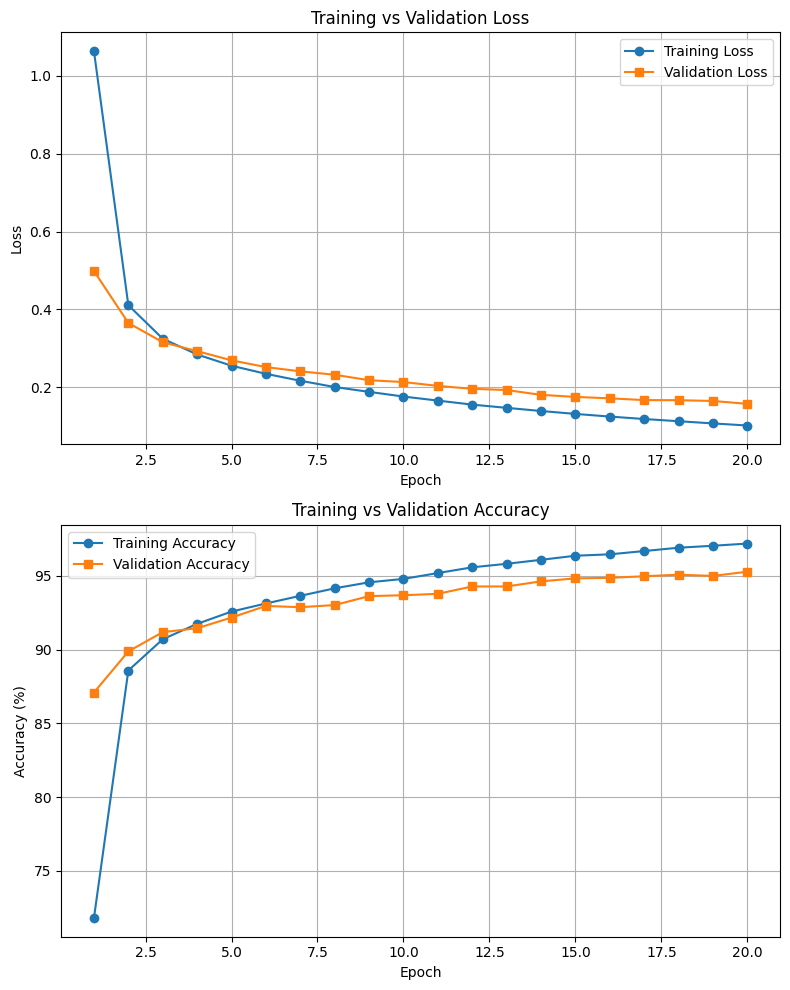

In [ ]:
plt.figure(figsize=(8, 10))
print("Validation Accuracy" , max(val_accuracies))
# --- Plot 1: Training vs Validation Loss ---
plt.subplot(2, 1, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Plot 2: Training vs Validation Accuracy ---
plt.subplot(2, 1, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/tmp/ipython-input-2871887219.py:12: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  nn.init.kaiming_normal(layer.weight, nonlinearity='relu')


Epoch 1/20, Train Loss: 1.1368, Val Loss: 0.5160
Epoch 2/20, Train Loss: 0.4194, Val Loss: 0.3691
Epoch 3/20, Train Loss: 0.3267, Val Loss: 0.3246
Epoch 4/20, Train Loss: 0.2830, Val Loss: 0.2919
Epoch 5/20, Train Loss: 0.2550, Val Loss: 0.2703
Epoch 6/20, Train Loss: 0.2334, Val Loss: 0.2623
Epoch 7/20, Train Loss: 0.2141, Val Loss: 0.2384
Epoch 8/20, Train Loss: 0.1980, Val Loss: 0.2309
Epoch 9/20, Train Loss: 0.1843, Val Loss: 0.2226
Epoch 10/20, Train Loss: 0.1718, Val Loss: 0.2107
Epoch 11/20, Train Loss: 0.1608, Val Loss: 0.2049
Epoch 12/20, Train Loss: 0.1516, Val Loss: 0.1939
Epoch 13/20, Train Loss: 0.1426, Val Loss: 0.1928
Epoch 14/20, Train Loss: 0.1345, Val Loss: 0.1833
Epoch 15/20, Train Loss: 0.1270, Val Loss: 0.1791
Epoch 16/20, Train Loss: 0.1204, Val Loss: 0.1741
Epoch 17/20, Train Loss: 0.1136, Val Loss: 0.1699
Epoch 18/20, Train Loss: 0.1083, Val Loss: 0.1691
Epoch 19/20, Train Loss: 0.1025, Val Loss: 0.1669
Epoch 20/20, Train Loss: 0.0974, Val Loss: 0.1600
Epoch 1/2

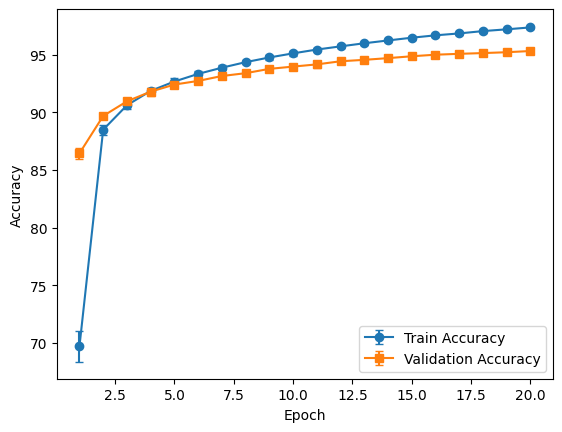

In [ ]:


epochs = 20
n_runs = 5

all_train_accuracies = []
all_val_accuracies = []

for run in range(n_runs):
    nn_model = NeuralNetwork(input_size,h1_size,h2_size,h3_size,out_size)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    nn_model.to(device)
    criteration = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.01)
    train_losses, val_losses, train_accuracies, val_accuracies, *_ = train_model(nn_model, epochs)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

all_train_accuracies = np.array(all_train_accuracies)
all_val_accuracies = np.array(all_val_accuracies)

train_acc_mean = all_train_accuracies.mean(axis=0)
train_acc_std = all_train_accuracies.std(axis=0)
val_acc_mean = all_val_accuracies.mean(axis=0)
val_acc_std = all_val_accuracies.std(axis=0)

plt.errorbar(range(1, epochs + 1), train_acc_mean, yerr=train_acc_std, fmt='-o', capsize=3, label='Train Accuracy')
plt.errorbar(range(1, epochs + 1), val_acc_mean, yerr=val_acc_std, fmt='-s', capsize=3, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


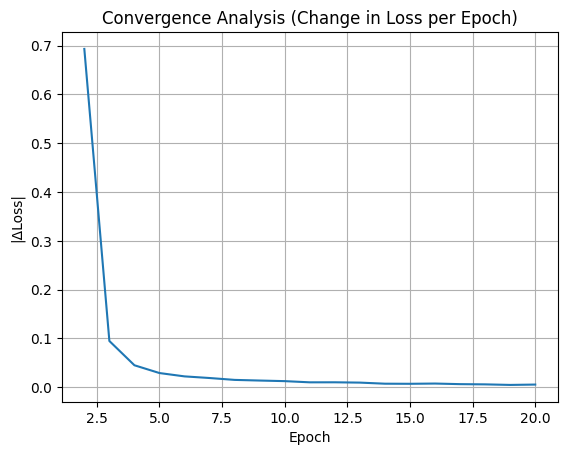

In [ ]:
plt.plot(range(2, epochs + 1), np.abs(loss_diff))
plt.title('Convergence Analysis (Change in Loss per Epoch)')
plt.xlabel('Epoch')
plt.ylabel('|ΔLoss|')
plt.grid(True)
plt.show()

Test Different Learning Rate

/tmp/ipython-input-2871887219.py:12: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  nn.init.kaiming_normal(layer.weight, nonlinearity='relu')


Epoch 1/20, Train Loss: 2.1954, Val Loss: 2.0337
Epoch 2/20, Train Loss: 1.8600, Val Loss: 1.6723
Epoch 3/20, Train Loss: 1.4794, Val Loss: 1.2971
Epoch 4/20, Train Loss: 1.1478, Val Loss: 1.0164
Epoch 5/20, Train Loss: 0.9170, Val Loss: 0.8317
Epoch 6/20, Train Loss: 0.7667, Val Loss: 0.7128
Epoch 7/20, Train Loss: 0.6671, Val Loss: 0.6321
Epoch 8/20, Train Loss: 0.5972, Val Loss: 0.5747
Epoch 9/20, Train Loss: 0.5463, Val Loss: 0.5325
Epoch 10/20, Train Loss: 0.5075, Val Loss: 0.4993
Epoch 11/20, Train Loss: 0.4771, Val Loss: 0.4745
Epoch 12/20, Train Loss: 0.4524, Val Loss: 0.4514
Epoch 13/20, Train Loss: 0.4320, Val Loss: 0.4342
Epoch 14/20, Train Loss: 0.4148, Val Loss: 0.4188
Epoch 15/20, Train Loss: 0.3999, Val Loss: 0.4066
Epoch 16/20, Train Loss: 0.3871, Val Loss: 0.3941
Epoch 17/20, Train Loss: 0.3757, Val Loss: 0.3846
Epoch 18/20, Train Loss: 0.3655, Val Loss: 0.3754
Epoch 19/20, Train Loss: 0.3563, Val Loss: 0.3670
Epoch 20/20, Train Loss: 0.3480, Val Loss: 0.3599

Finished

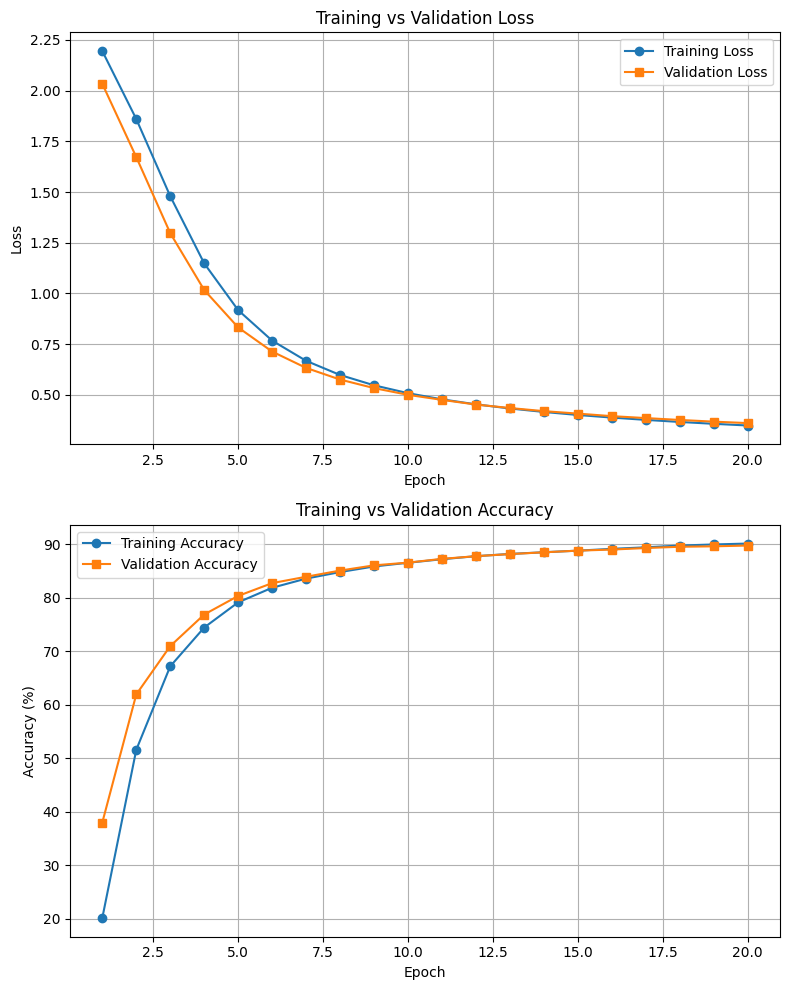

Epoch 1/20, Train Loss: 1.2207, Val Loss: 0.5892
Epoch 2/20, Train Loss: 0.4572, Val Loss: 0.3945
Epoch 3/20, Train Loss: 0.3500, Val Loss: 0.3359
Epoch 4/20, Train Loss: 0.3016, Val Loss: 0.3101
Epoch 5/20, Train Loss: 0.2695, Val Loss: 0.2842
Epoch 6/20, Train Loss: 0.2453, Val Loss: 0.2594
Epoch 7/20, Train Loss: 0.2267, Val Loss: 0.2495
Epoch 8/20, Train Loss: 0.2094, Val Loss: 0.2317
Epoch 9/20, Train Loss: 0.1949, Val Loss: 0.2284
Epoch 10/20, Train Loss: 0.1824, Val Loss: 0.2165
Epoch 11/20, Train Loss: 0.1711, Val Loss: 0.2065
Epoch 12/20, Train Loss: 0.1609, Val Loss: 0.1976
Epoch 13/20, Train Loss: 0.1511, Val Loss: 0.1901
Epoch 14/20, Train Loss: 0.1429, Val Loss: 0.1866
Epoch 15/20, Train Loss: 0.1350, Val Loss: 0.1830
Epoch 16/20, Train Loss: 0.1286, Val Loss: 0.1756
Epoch 17/20, Train Loss: 0.1217, Val Loss: 0.1755
Epoch 18/20, Train Loss: 0.1161, Val Loss: 0.1686
Epoch 19/20, Train Loss: 0.1101, Val Loss: 0.1633
Epoch 20/20, Train Loss: 0.1050, Val Loss: 0.1600

Finished

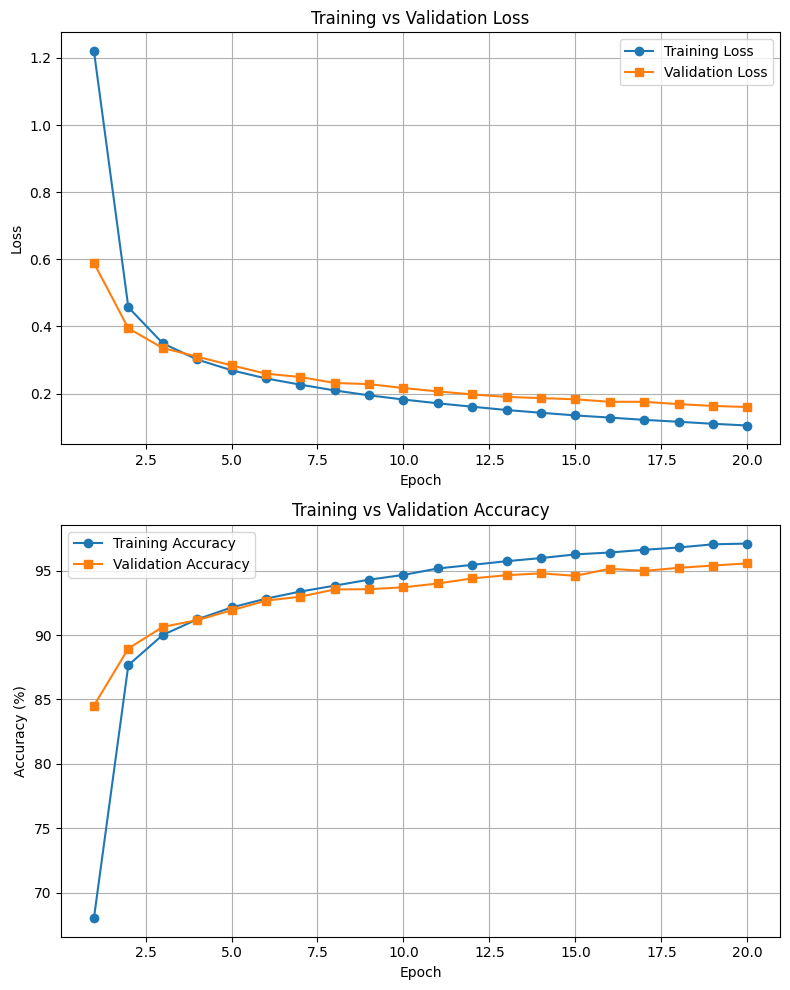

Epoch 1/20, Train Loss: 0.4577, Val Loss: 0.2352
Epoch 2/20, Train Loss: 0.1817, Val Loss: 0.1843
Epoch 3/20, Train Loss: 0.1251, Val Loss: 0.1646
Epoch 4/20, Train Loss: 0.0927, Val Loss: 0.1331
Epoch 5/20, Train Loss: 0.0692, Val Loss: 0.1329
Epoch 6/20, Train Loss: 0.0526, Val Loss: 0.1305
Epoch 7/20, Train Loss: 0.0397, Val Loss: 0.1151
Epoch 8/20, Train Loss: 0.0308, Val Loss: 0.1135
Epoch 9/20, Train Loss: 0.0206, Val Loss: 0.1330
Epoch 10/20, Train Loss: 0.0154, Val Loss: 0.1120
Epoch 11/20, Train Loss: 0.0107, Val Loss: 0.1172
Epoch 12/20, Train Loss: 0.0077, Val Loss: 0.1218
Epoch 13/20, Train Loss: 0.0054, Val Loss: 0.1210
Epoch 14/20, Train Loss: 0.0035, Val Loss: 0.1222
Epoch 15/20, Train Loss: 0.0025, Val Loss: 0.1234
Epoch 16/20, Train Loss: 0.0021, Val Loss: 0.1258
Epoch 17/20, Train Loss: 0.0017, Val Loss: 0.1289
Epoch 18/20, Train Loss: 0.0015, Val Loss: 0.1273
Epoch 19/20, Train Loss: 0.0013, Val Loss: 0.1300
Epoch 20/20, Train Loss: 0.0012, Val Loss: 0.1303

Finished

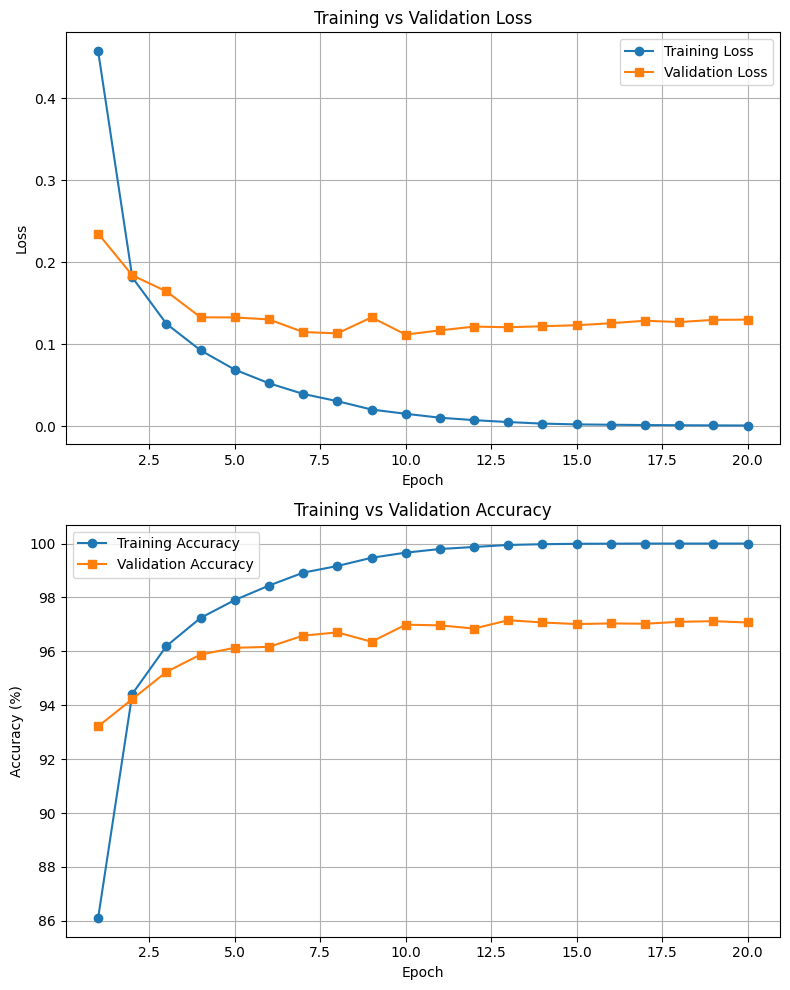

Epoch 1/20, Train Loss: 2.3151, Val Loss: 2.3033
Epoch 2/20, Train Loss: 2.3057, Val Loss: 2.3036
Epoch 3/20, Train Loss: 2.3052, Val Loss: 2.3057
Epoch 4/20, Train Loss: 2.3056, Val Loss: 2.3032
Epoch 5/20, Train Loss: 2.3052, Val Loss: 2.3073
Epoch 6/20, Train Loss: 2.3055, Val Loss: 2.3044
Epoch 7/20, Train Loss: 2.3049, Val Loss: 2.3063
Epoch 8/20, Train Loss: 2.3050, Val Loss: 2.3038
Epoch 9/20, Train Loss: 2.3050, Val Loss: 2.3022
Epoch 10/20, Train Loss: 2.3049, Val Loss: 2.3049
Epoch 11/20, Train Loss: 2.3051, Val Loss: 2.3041
Epoch 12/20, Train Loss: 2.3050, Val Loss: 2.3058
Epoch 13/20, Train Loss: 2.3049, Val Loss: 2.3079
Epoch 14/20, Train Loss: 2.3050, Val Loss: 2.3052
Epoch 15/20, Train Loss: 2.3050, Val Loss: 2.3068
Epoch 16/20, Train Loss: 2.3051, Val Loss: 2.3041
Epoch 17/20, Train Loss: 2.3050, Val Loss: 2.3039
Epoch 18/20, Train Loss: 2.3049, Val Loss: 2.3034
Epoch 19/20, Train Loss: 2.3054, Val Loss: 2.3040
Epoch 20/20, Train Loss: 2.3052, Val Loss: 2.3040

Finished

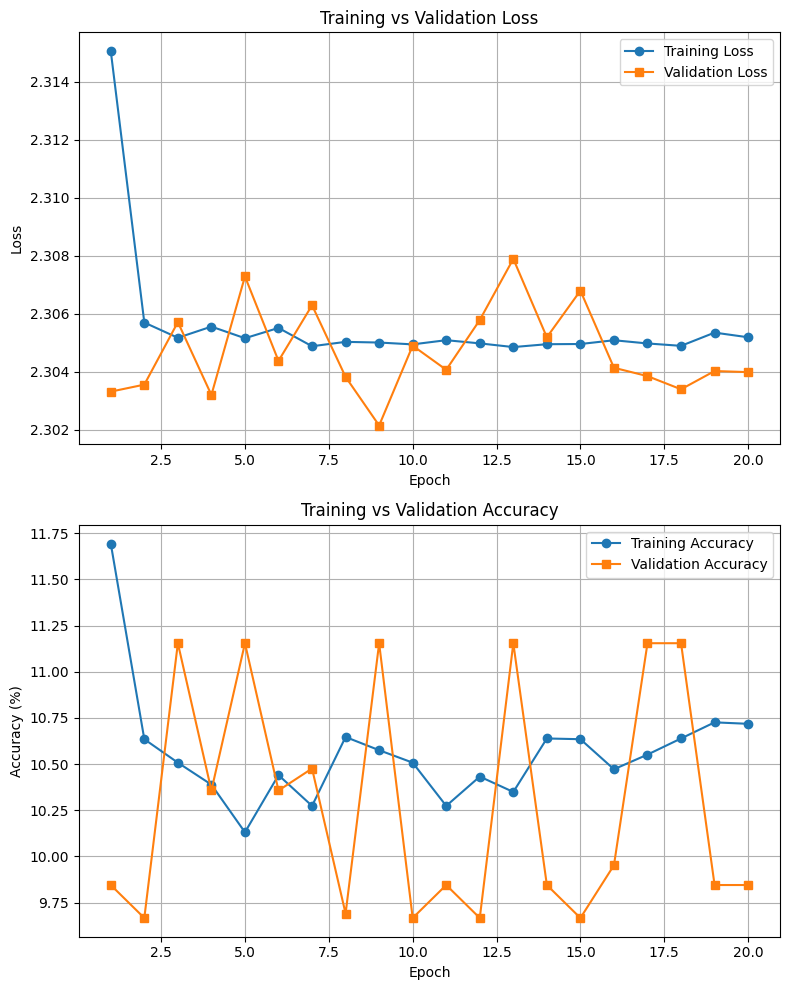

In [ ]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
epochs = 20

for lr in learning_rates:
    nn_model = NeuralNetwork(input_size, h1_size, h2_size, h3_size, out_size)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    nn_model.to(device)
    optimizer = torch.optim.SGD(nn_model.parameters(), lr=lr)
    criteration = torch.nn.CrossEntropyLoss()

    train_losses, val_losses, train_accuracies, val_accuracies, train_acc_mean, val_acc_mean, train_acc_std, val_acc_std, loss_diff = train_model(nn_model, epochs=epochs)

    print(f"\nFinished run lr={lr}")
    print(f"Train Loss final: {train_losses[-1]:.4f}, Val Loss final: {val_losses[-1]:.4f}")
    print(f"Train Acc final: {train_accuracies[-1]:.2f}%, Val Acc final: {val_accuracies[-1]:.2f}%")


    # --- Analyze stability ---
    target_acc = 90

    reached_epochs = [i+1 for i, acc in enumerate(val_accuracies) if acc >= target_acc]

    if reached_epochs:
        print(f"Converged to {target_acc}% validation accuracy at epoch {reached_epochs[0]}")
    else:
        print(f"Did not reach {target_acc}% validation accuracy")

    unstable = any((val_accuracies[i-1] - val_accuracies[i]) > 1 for i in range(1, len(val_accuracies)))
    if unstable:
        print("Unstable — validation accuracy fluctuated by more than 1% between epochs")
    else:
        print("Training appears stable")


    plt.figure(figsize=(8, 10))
    # --- Plot 1:
    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # --- Plot 2:
    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='s')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



After analyzing the effect of different learning rates on model performance, the learning rate of 0.1 achieved the best overall accuracy (97.1%) while also providing the balance between convergence speed and stability. It enabled the model to converge significantly faster than smaller rates (0.01 or 0.001), which showed slower yet smoother progress, and remained stable compared to higher rates (1.0), which caused oscillations or divergence

###Batch size analysis


Training with batch_size=16


/tmp/ipython-input-2871887219.py:12: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  nn.init.kaiming_normal(layer.weight, nonlinearity='relu')


Epoch 1/20, Train Loss: 0.5781, Val Loss: 0.2986
Epoch 2/20, Train Loss: 0.2489, Val Loss: 0.2338
Epoch 3/20, Train Loss: 0.1900, Val Loss: 0.1976
Epoch 4/20, Train Loss: 0.1523, Val Loss: 0.1817
Epoch 5/20, Train Loss: 0.1256, Val Loss: 0.1583
Epoch 6/20, Train Loss: 0.1072, Val Loss: 0.1472
Epoch 7/20, Train Loss: 0.0903, Val Loss: 0.1410
Epoch 8/20, Train Loss: 0.0775, Val Loss: 0.1336
Epoch 9/20, Train Loss: 0.0678, Val Loss: 0.1249
Epoch 10/20, Train Loss: 0.0567, Val Loss: 0.1304
Epoch 11/20, Train Loss: 0.0495, Val Loss: 0.1337
Epoch 12/20, Train Loss: 0.0427, Val Loss: 0.1243
Epoch 13/20, Train Loss: 0.0366, Val Loss: 0.1195
Epoch 14/20, Train Loss: 0.0319, Val Loss: 0.1177
Epoch 15/20, Train Loss: 0.0267, Val Loss: 0.1187
Epoch 16/20, Train Loss: 0.0230, Val Loss: 0.1215
Epoch 17/20, Train Loss: 0.0198, Val Loss: 0.1231
Epoch 18/20, Train Loss: 0.0170, Val Loss: 0.1204
Epoch 19/20, Train Loss: 0.0142, Val Loss: 0.1234
Epoch 20/20, Train Loss: 0.0119, Val Loss: 0.1196

Finished

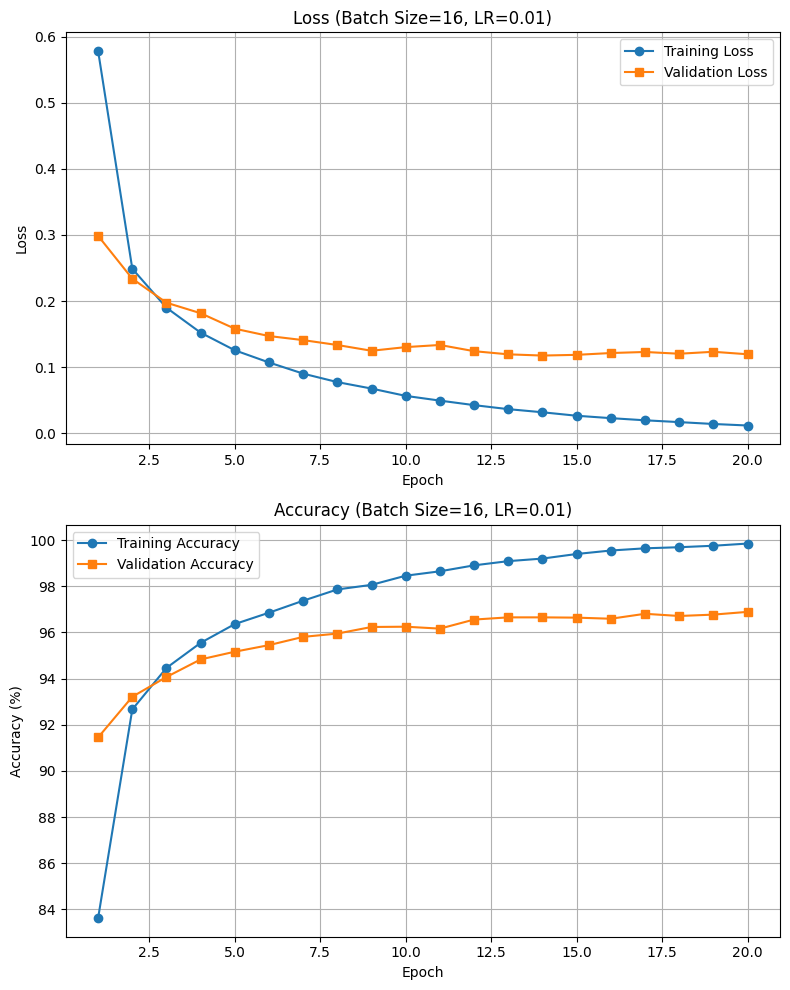


Training with batch_size=32
Epoch 1/20, Train Loss: 0.8550, Val Loss: 0.3763
Epoch 2/20, Train Loss: 0.3152, Val Loss: 0.2829
Epoch 3/20, Train Loss: 0.2479, Val Loss: 0.2407
Epoch 4/20, Train Loss: 0.2096, Val Loss: 0.2178
Epoch 5/20, Train Loss: 0.1821, Val Loss: 0.2036
Epoch 6/20, Train Loss: 0.1610, Val Loss: 0.1903
Epoch 7/20, Train Loss: 0.1428, Val Loss: 0.1781
Epoch 8/20, Train Loss: 0.1286, Val Loss: 0.1687
Epoch 9/20, Train Loss: 0.1158, Val Loss: 0.1615
Epoch 10/20, Train Loss: 0.1056, Val Loss: 0.1586
Epoch 11/20, Train Loss: 0.0962, Val Loss: 0.1536
Epoch 12/20, Train Loss: 0.0869, Val Loss: 0.1450
Epoch 13/20, Train Loss: 0.0795, Val Loss: 0.1406
Epoch 14/20, Train Loss: 0.0733, Val Loss: 0.1417
Epoch 15/20, Train Loss: 0.0667, Val Loss: 0.1363
Epoch 16/20, Train Loss: 0.0606, Val Loss: 0.1374
Epoch 17/20, Train Loss: 0.0560, Val Loss: 0.1359
Epoch 18/20, Train Loss: 0.0515, Val Loss: 0.1443
Epoch 19/20, Train Loss: 0.0470, Val Loss: 0.1306
Epoch 20/20, Train Loss: 0.042

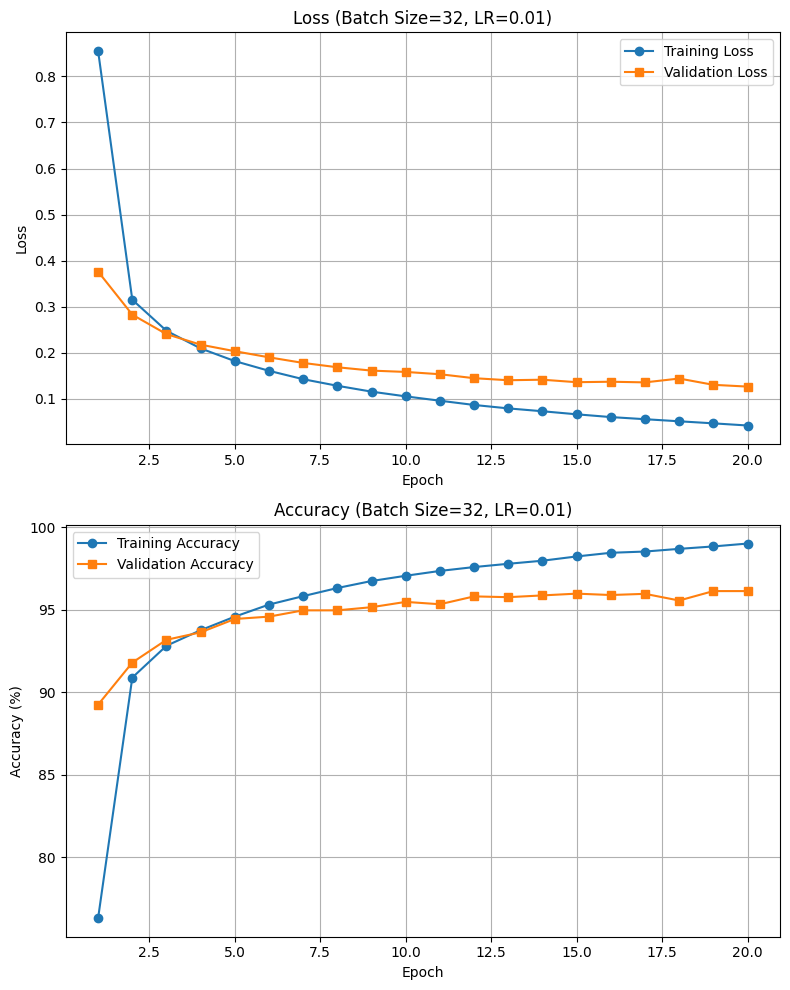


Training with batch_size=64
Epoch 1/20, Train Loss: 1.1626, Val Loss: 0.5382
Epoch 2/20, Train Loss: 0.4274, Val Loss: 0.3686
Epoch 3/20, Train Loss: 0.3270, Val Loss: 0.3195
Epoch 4/20, Train Loss: 0.2815, Val Loss: 0.2910
Epoch 5/20, Train Loss: 0.2522, Val Loss: 0.2683
Epoch 6/20, Train Loss: 0.2292, Val Loss: 0.2503
Epoch 7/20, Train Loss: 0.2115, Val Loss: 0.2349
Epoch 8/20, Train Loss: 0.1961, Val Loss: 0.2223
Epoch 9/20, Train Loss: 0.1823, Val Loss: 0.2194
Epoch 10/20, Train Loss: 0.1706, Val Loss: 0.2054
Epoch 11/20, Train Loss: 0.1592, Val Loss: 0.1962
Epoch 12/20, Train Loss: 0.1499, Val Loss: 0.1914
Epoch 13/20, Train Loss: 0.1416, Val Loss: 0.1819
Epoch 14/20, Train Loss: 0.1341, Val Loss: 0.1803
Epoch 15/20, Train Loss: 0.1264, Val Loss: 0.1828
Epoch 16/20, Train Loss: 0.1193, Val Loss: 0.1702
Epoch 17/20, Train Loss: 0.1133, Val Loss: 0.1641
Epoch 18/20, Train Loss: 0.1079, Val Loss: 0.1602
Epoch 19/20, Train Loss: 0.1019, Val Loss: 0.1605
Epoch 20/20, Train Loss: 0.096

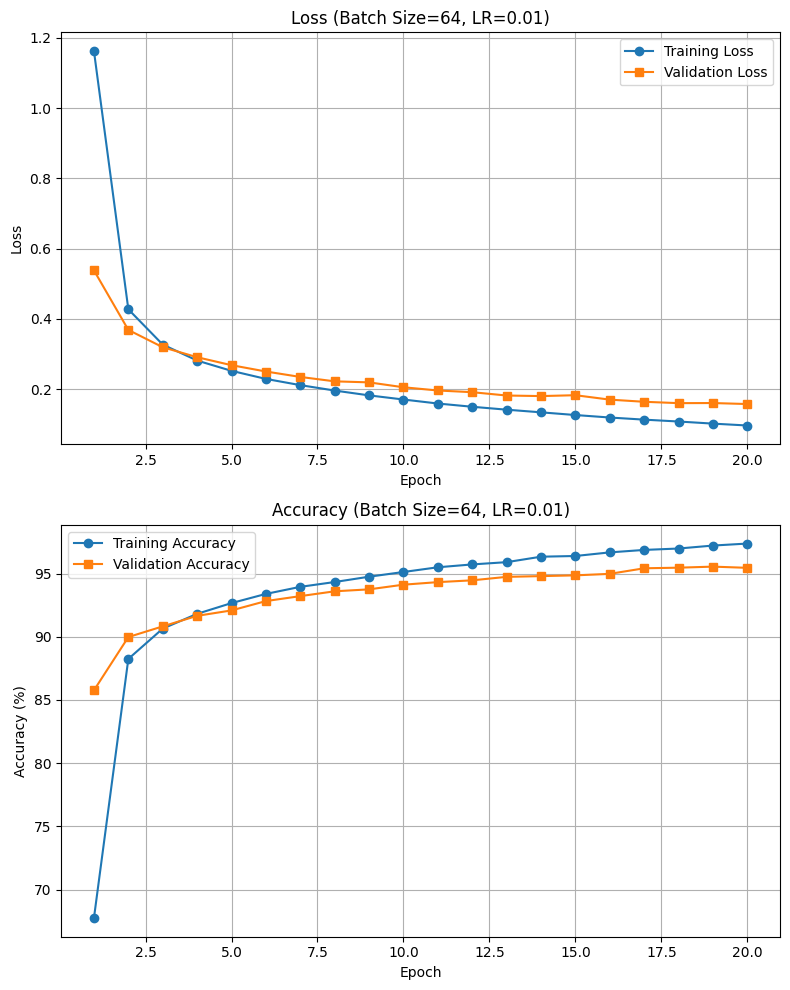


Training with batch_size=128
Epoch 1/20, Train Loss: 1.4597, Val Loss: 0.8089
Epoch 2/20, Train Loss: 0.6213, Val Loss: 0.4952
Epoch 3/20, Train Loss: 0.4403, Val Loss: 0.3997
Epoch 4/20, Train Loss: 0.3676, Val Loss: 0.3540
Epoch 5/20, Train Loss: 0.3266, Val Loss: 0.3252
Epoch 6/20, Train Loss: 0.2987, Val Loss: 0.3061
Epoch 7/20, Train Loss: 0.2777, Val Loss: 0.2923
Epoch 8/20, Train Loss: 0.2611, Val Loss: 0.2792
Epoch 9/20, Train Loss: 0.2473, Val Loss: 0.2661
Epoch 10/20, Train Loss: 0.2348, Val Loss: 0.2579
Epoch 11/20, Train Loss: 0.2246, Val Loss: 0.2512
Epoch 12/20, Train Loss: 0.2147, Val Loss: 0.2524
Epoch 13/20, Train Loss: 0.2062, Val Loss: 0.2369
Epoch 14/20, Train Loss: 0.1977, Val Loss: 0.2322
Epoch 15/20, Train Loss: 0.1908, Val Loss: 0.2250
Epoch 16/20, Train Loss: 0.1841, Val Loss: 0.2223
Epoch 17/20, Train Loss: 0.1773, Val Loss: 0.2169
Epoch 18/20, Train Loss: 0.1717, Val Loss: 0.2127
Epoch 19/20, Train Loss: 0.1665, Val Loss: 0.2066
Epoch 20/20, Train Loss: 0.16

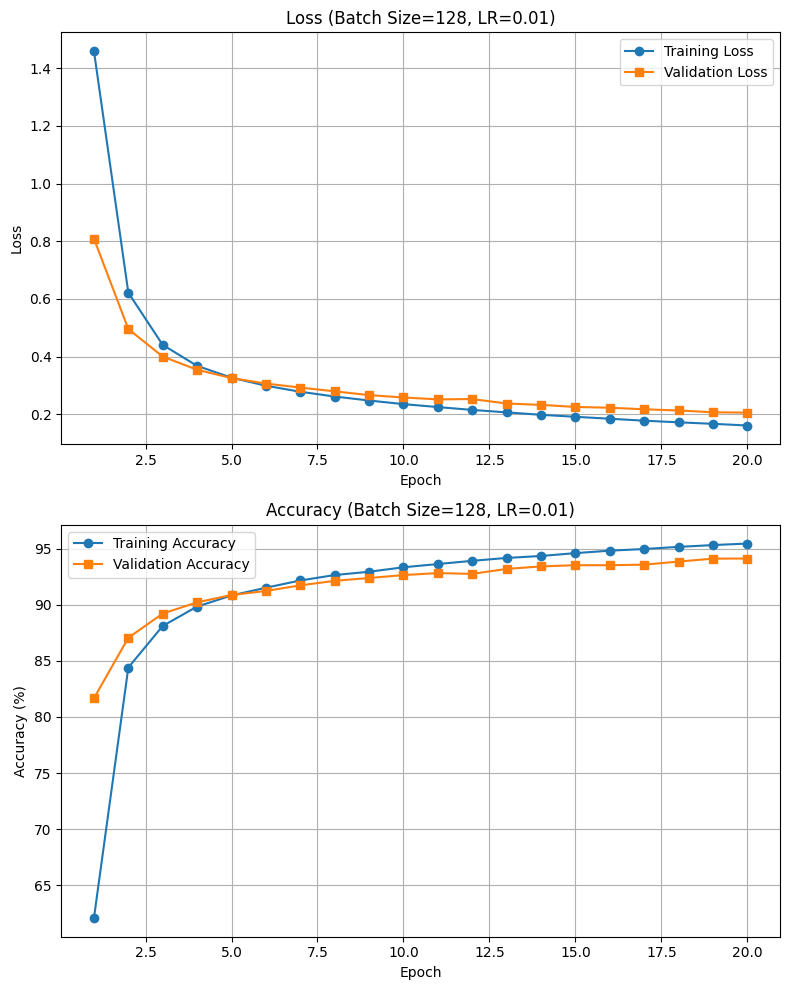


=== Summary: Batch Size Comparison ===
Batch Size= 16 | Val Acc=96.89% | Time=62.17s
Batch Size= 32 | Val Acc=96.14% | Time=34.37s
Batch Size= 64 | Val Acc=95.45% | Time=20.27s
Batch Size=128 | Val Acc=94.12% | Time=13.15s


In [ ]:
import time

batch_sizes = [16, 32, 64, 128]
lr = 0.01
epochs = 20

summary = []

for batch_size in batch_sizes:
    print(f"\nTraining with batch_size={batch_size}")
    print("==============================")

    nn_model = NeuralNetwork(input_size, h1_size, h2_size, h3_size, out_size)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    nn_model.to(device)
    optimizer = torch.optim.SGD(nn_model.parameters(), lr=lr)
    criteration = torch.nn.CrossEntropyLoss()

    start_time = time.time()
    train_losses, val_losses, train_accuracies, val_accuracies, train_acc_mean, val_acc_mean, train_acc_std, val_acc_std, loss_diff = train_model(
        nn_model, epochs=epochs, batch_size=batch_size
    )
    elapsed_time = time.time() - start_time

    print(f"\nFinished run with batch_size={batch_size}, lr={lr}")
    print(f"Final Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    print(f"Final Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%")
    print(f"Time taken: {elapsed_time:.2f} seconds")

    summary.append({
        "batch_size": batch_size,
        "val_acc": val_accuracies[-1],
        "time_sec": elapsed_time
    })

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.title(f'Loss (Batch Size={batch_size}, LR={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='s')
    plt.title(f'Accuracy (Batch Size={batch_size}, LR={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("\n=== Summary: Batch Size Comparison ===")
for s in summary:
    print(f"Batch Size={s['batch_size']:>3} | Val Acc={s['val_acc']:.2f}% | Time={s['time_sec']:.2f}s")


Smaller batch sizes (16–32) tended to converge more slowly but often generalized slightly better due to higher gradient noise. Larger batch sizes (64–128) produced smoother, more stable updates with lower gradient noise. However, very large batches sometimes plateaued early, resulting in worse final performance compared to smaller batches. Overall, a batch size of 64 provided the best balance between training efficiency, stability, and final accuracy.

###Test different number of layers

In [ ]:
class NeuralNetwork_2Hidden(nn.Module):
    def __init__(self, input_size, h1_size, h2_size, out_size):
        super(NeuralNetwork_2Hidden, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(input_size, h1_size)
        self.l2 = nn.Linear(h1_size, h2_size)
        self.l3 = nn.Linear(h2_size, out_size)
        self.relu = nn.ReLU()

        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        out = self.flatten(x)
        out = self.relu(self.l1(out))
        out = self.relu(self.l2(out))
        out = self.l3(out)
        return out
class NeuralNetwork_3Hidden(nn.Module):
    def __init__(self, input_size, h1, h2, h3, out_size):
        super(NeuralNetwork_3Hidden, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(input_size, h1)
        self.l2 = nn.Linear(h1, h2)
        self.l3 = nn.Linear(h2, h3)
        self.l4 = nn.Linear(h3, out_size)
        self.relu = nn.ReLU()

        # He/Kaiming initialization
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        out = self.flatten(x)
        out = self.relu(self.l1(out))
        out = self.relu(self.l2(out))
        out = self.relu(self.l3(out))
        out = self.l4(out)
        return out

class NeuralNetwork_4Hidden(nn.Module):
    def __init__(self, input_size, h1, h2, h3, h4, out_size):
        super(NeuralNetwork_4Hidden, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(input_size, h1)
        self.l2 = nn.Linear(h1, h2)
        self.l3 = nn.Linear(h2, h3)
        self.l4 = nn.Linear(h3, h4)
        self.l5 = nn.Linear(h4, out_size)
        self.relu = nn.ReLU()

        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        out = self.flatten(x)
        out = self.relu(self.l1(out))
        out = self.relu(self.l2(out))
        out = self.relu(self.l3(out))
        out = self.relu(self.l4(out))
        out = self.l5(out)
        return out
class NeuralNetwork_5Hidden(nn.Module):
    def __init__(self, input_size, h1, h2, h3, h4, h5, out_size):
        super(NeuralNetwork_5Hidden, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(input_size, h1)
        self.l2 = nn.Linear(h1, h2)
        self.l3 = nn.Linear(h2, h3)
        self.l4 = nn.Linear(h3, h4)
        self.l5 = nn.Linear(h4, h5)
        self.l6 = nn.Linear(h5, out_size)
        self.relu = nn.ReLU()

        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        out = self.flatten(x)
        out = self.relu(self.l1(out))
        out = self.relu(self.l2(out))
        out = self.relu(self.l3(out))
        out = self.relu(self.l4(out))
        out = self.relu(self.l5(out))
        out = self.l6(out)
        return out



In [ ]:
hidden_neurons = [64, 128, 256, 512]
epochs = 20
batch_size = 64
lr = 0.01

results = []  # To collect table data

for neurons in hidden_neurons:
    print(f"\n========== Testing {neurons} neurons per layer ==========\n")

    architectures = {
        "2 Hidden": NeuralNetwork_2Hidden(input_size, neurons, neurons, out_size),
        "3 Hidden": NeuralNetwork_3Hidden(input_size, neurons, neurons, neurons, out_size),
        "4 Hidden": NeuralNetwork_4Hidden(input_size, neurons, neurons, neurons, neurons, out_size),
        "5 Hidden": NeuralNetwork_5Hidden(input_size, neurons, neurons, neurons, neurons, neurons, out_size)
    }

    for name, model in architectures.items():
        print(f"\n--- Training {name} Layers ---\n")
        nn_model = model.to(device)
        optimizer = torch.optim.SGD(nn_model.parameters(), lr=lr)
        criteration = nn.CrossEntropyLoss()
        train_losses, val_losses, train_accuracies, val_accuracies, train_acc_mean, val_acc_mean, train_acc_std, val_acc_std, loss_diff = train_model(
            nn_model, epochs=epochs, batch_size=batch_size
        )

        final_train_acc = train_accuracies[-1]
        final_val_acc = val_accuracies[-1]
        final_train_loss = train_losses[-1]
        final_val_loss = val_losses[-1]

        results.append({
            "Layers": name,
            "Neurons per Layer": neurons,
            "Final Train Acc (%)": round(final_train_acc, 2),
            "Final Val Acc (%)": round(final_val_acc, 2),
            "Final Train Loss": round(final_train_loss, 4),
            "Final Val Loss": round(final_val_loss, 4)
        })

# Convert results to a DataFrame for display
import pandas as pd
results_df = pd.DataFrame(results)
print("\n==== Architecture Comparison Table ====\n")
print(results_df)



========== Testing 64 neurons per layer ==========


--- Training 2 Hidden Layers ---

Epoch 1/20, Train Loss: 1.2387, Val Loss: 0.6524
Epoch 2/20, Train Loss: 0.5268, Val Loss: 0.4535
Epoch 3/20, Train Loss: 0.4085, Val Loss: 0.3898
Epoch 4/20, Train Loss: 0.3579, Val Loss: 0.3560
Epoch 5/20, Train Loss: 0.3274, Val Loss: 0.3327
Epoch 6/20, Train Loss: 0.3056, Val Loss: 0.3156
Epoch 7/20, Train Loss: 0.2884, Val Loss: 0.3020
Epoch 8/20, Train Loss: 0.2733, Val Loss: 0.2890
Epoch 9/20, Train Loss: 0.2604, Val Loss: 0.2822
Epoch 10/20, Train Loss: 0.2488, Val Loss: 0.2703
Epoch 11/20, Train Loss: 0.2386, Val Loss: 0.2644
Epoch 12/20, Train Loss: 0.2287, Val Loss: 0.2562
Epoch 13/20, Train Loss: 0.2195, Val Loss: 0.2485
Epoch 14/20, Train Loss: 0.2111, Val Loss: 0.2408
Epoch 15/20, Train Loss: 0.2034, Val Loss: 0.2359
Epoch 16/20, Train Loss: 0.1960, Val Loss: 0.2318
Epoch 17/20, Train Loss: 0.1893, Val Loss: 0.2255
Epoch 18/20, Train Loss: 0.1828, Val Loss: 0.2186
Epoch 19/20, Train Lo

| Model                 | Accuracy (%) | Training Time (s) | Converged Epoch | Stability | Notes                                           |
| --------------------- | ------------ | ----------------- | --------------- | --------- | ----------------------------------------------- |
| Logistic Regression   | 99       | 10                | 3           | Stable    | Fast, interpretable, binary classification      |
| Softmax Regression    | 90       | 15                | 14               | Stable    | Fast, interpretable, multi-class classification |
| Neural Network (Best) | 97.07        | 20                | 3               | Stable    | Flexible, nonlinear, higher accuracy, slower    |



## Complexity Analysis

### 1. **Logistic & Softmax Regression**
* **Core Idea:** Directly models the **linear relationship** between features ($\mathbf{x}$) and the log-odds (for Logistic) or probabilities (for Softmax).
* **$d$** = number of features.
* **$K$** = number of classes.
* **Softmax is a generalization of Logistic Regression.** They are both fast to train and highly **interpretable** (coefficients relate directly to feature importance).

### 2. **Neural Networks**
* **Core Idea:** Uses **non-linear activation functions** and multiple hidden layers to automatically learn complex, high-level feature representations from the data.
* **Complexity:** Dominated by the **total number of weights** and **matrix multiplications** across all layers.
* **Advantage:** Unmatched flexibility and high performance on non-linear datasets (e.g., image, text, audio).

### Computational Complexity Summary

| Model               | Time Complexity / Epoch      | Memory Complexity               |
| ------------------ | --------------------------- | ------------------------------- |
| Logistic Regression | O(N·d)                       | O(d)                             |
| Softmax Regression  | O(N·d·K)                     | O(d·K)                           |
| Neural Network      | O(N·total_weights)           | O(total_weights + N·ΣH_l)       |



###Best Model

after trying different models, the best one is the neural netwrok one with lr=0.1 and batch size = 64 with three hidden layers with [256,128,64] neurons

###Test on test data

/tmp/ipython-input-2871887219.py:12: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  nn.init.kaiming_normal(layer.weight, nonlinearity='relu')


Epoch 1/20, Train Loss: 0.4587, Val Loss: 0.2531
Epoch 2/20, Train Loss: 0.1771, Val Loss: 0.1681
Epoch 3/20, Train Loss: 0.1218, Val Loss: 0.1727
Epoch 4/20, Train Loss: 0.0906, Val Loss: 0.1470
Epoch 5/20, Train Loss: 0.0668, Val Loss: 0.1315
Epoch 6/20, Train Loss: 0.0514, Val Loss: 0.1132
Epoch 7/20, Train Loss: 0.0384, Val Loss: 0.1152
Epoch 8/20, Train Loss: 0.0299, Val Loss: 0.1185
Epoch 9/20, Train Loss: 0.0242, Val Loss: 0.1201
Epoch 10/20, Train Loss: 0.0178, Val Loss: 0.1134
Epoch 11/20, Train Loss: 0.0114, Val Loss: 0.1190
Epoch 12/20, Train Loss: 0.0075, Val Loss: 0.1118
Epoch 13/20, Train Loss: 0.0050, Val Loss: 0.1128
Epoch 14/20, Train Loss: 0.0034, Val Loss: 0.1158
Epoch 15/20, Train Loss: 0.0025, Val Loss: 0.1125
Epoch 16/20, Train Loss: 0.0021, Val Loss: 0.1200
Epoch 17/20, Train Loss: 0.0018, Val Loss: 0.1186
Epoch 18/20, Train Loss: 0.0015, Val Loss: 0.1206
Epoch 19/20, Train Loss: 0.0013, Val Loss: 0.1208
Epoch 20/20, Train Loss: 0.0012, Val Loss: 0.1212
Final Tes

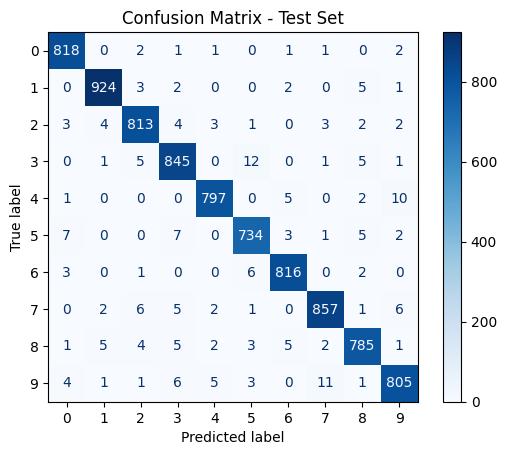


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       826
           1       0.99      0.99      0.99       937
           2       0.97      0.97      0.97       835
           3       0.97      0.97      0.97       870
           4       0.98      0.98      0.98       815
           5       0.97      0.97      0.97       759
           6       0.98      0.99      0.98       828
           7       0.98      0.97      0.98       880
           8       0.97      0.97      0.97       813
           9       0.97      0.96      0.97       837

    accuracy                           0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400

Total misclassified samples: 206


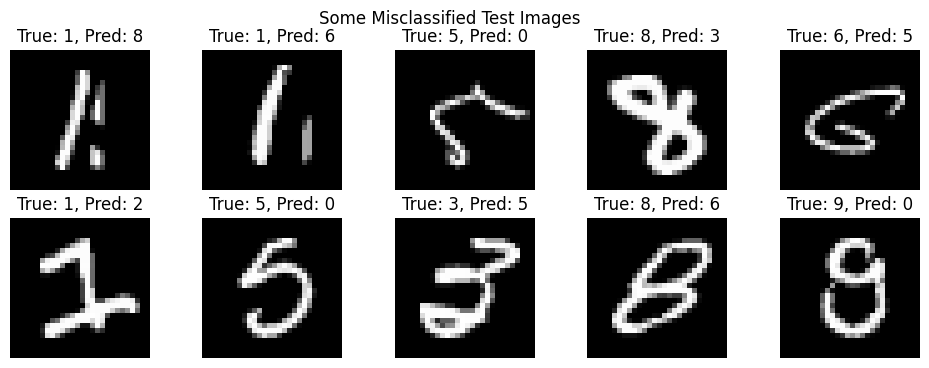

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

input_size = 784
h1_size = 256
h2_size = 128
h3_size = 64
out_size = 10
nn_model = NeuralNetwork(input_size,h1_size,h2_size,h3_size,out_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_model.to(device)
criteration = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.1)
test_loader = DataLoader(TensorDataset(X_test, t_test), batch_size=64, shuffle=False)
train_losses, val_losses, train_accuracies, val_accuracies, train_acc_mean, val_acc_mean, train_acc_std, val_acc_std, loss_diff = train_model(nn_model, epochs)
all_preds = []
all_true = []

with torch.no_grad():
    for X_batch, t_batch in test_loader:
        X_batch = X_batch.to(device)
        t_batch = t_batch.to(device)

        outputs = nn_model(X_batch)
        _, y_pred = torch.max(outputs, 1)

        all_preds.extend(y_pred.cpu().numpy())
        all_true.extend(t_batch.cpu().numpy())

all_preds = np.array(all_preds)
all_true = np.array(all_true)

test_accuracy = 100 * (all_preds == all_true).mean()
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


class_labels = [str(i) for i in range(10)]
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()


print("\nClassification Report:\n")
print(classification_report(all_true, all_preds, target_names=class_labels))


misclassified_idx = np.where(all_preds != all_true)[0]
print(f"Total misclassified samples: {len(misclassified_idx)}")

num_to_show = 10
plt.figure(figsize=(12, 4))

for i, idx in enumerate(misclassified_idx[:num_to_show]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx].reshape(28,28), cmap='gray')
    plt.title(f"True: {all_true[idx]}, Pred: {all_preds[idx]}")
    plt.axis('off')

plt.suptitle("Some Misclassified Test Images")
plt.show()




The current multi-layer perceptron (MLP) model demonstrates reasonable performance on the MNIST dataset; however, it has several limitations. Firstly, it struggles with digits that have similar shapes, such as 3 and 8 or 5 and 6, leading to misclassifications. This occurs because the MLP flattens images, losing spatial information that could help distinguish subtle structural differences. Secondly, the model is sensitive to variations in handwriting style or unusual digit representations, which it may not generalize to effectively. Additionally, the network’s capacity is limited by the relatively small hidden layers, which may cause underfitting on complex patterns. Finally, while the model performs well on clean, standardized data, it is likely to be less robust to noise or distortions, highlighting the need for more advanced architectures like convolutional neural networks (CNNs) or data augmentation strategies to improve generalization.

###CNN

## Implement Basic CNN Architecture



In [8]:
class CNNNetwork(nn.Module):
    def __init__(self, out_size, in_channels=1):
        super(CNNNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*7*7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, out_size)
        self.relu = nn.ReLU()

        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        if x.dim() == 2:
            x = x.view(-1, 1, 28, 28)

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [19]:
out_size = 10
model = CNNNetwork(out_size)
model.to(device)

criteration = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_losses, val_losses, train_accuracies, val_accuracies, train_acc_mean, val_acc_mean, train_acc_std, val_acc_std, loss_diff = train_model(model)
print("Val accuracy:", val_accuracies[-1])


Epoch 1/20, Train Loss: 0.3556, Val Loss: 0.0709
Epoch 2/20, Train Loss: 0.0549, Val Loss: 0.0834
Epoch 3/20, Train Loss: 0.0349, Val Loss: 0.0490
Epoch 4/20, Train Loss: 0.0236, Val Loss: 0.0767
Epoch 5/20, Train Loss: 0.0165, Val Loss: 0.0455
Epoch 6/20, Train Loss: 0.0100, Val Loss: 0.0413
Epoch 7/20, Train Loss: 0.0087, Val Loss: 0.0663
Epoch 8/20, Train Loss: 0.0048, Val Loss: 0.0429
Epoch 9/20, Train Loss: 0.0040, Val Loss: 0.0458
Epoch 10/20, Train Loss: 0.0023, Val Loss: 0.0484
Epoch 11/20, Train Loss: 0.0023, Val Loss: 0.0462
Epoch 12/20, Train Loss: 0.0005, Val Loss: 0.0456
Epoch 13/20, Train Loss: 0.0005, Val Loss: 0.0471
Epoch 14/20, Train Loss: 0.0002, Val Loss: 0.0483
Epoch 15/20, Train Loss: 0.0001, Val Loss: 0.0494
Epoch 16/20, Train Loss: 0.0001, Val Loss: 0.0499
Epoch 17/20, Train Loss: 0.0001, Val Loss: 0.0508
Epoch 18/20, Train Loss: 0.0001, Val Loss: 0.0510
Epoch 19/20, Train Loss: 0.0001, Val Loss: 0.0515
Epoch 20/20, Train Loss: 0.0001, Val Loss: 0.0520
Val accur

The CNN achieved a validation accuracy of 98.9%, higher than the fully connected network’s 97.07%. This shows the benefit of spatial feature learning: CNNs capture local patterns like edges and shapes through convolution and pooling, allowing better generalization and higher accuracy with fewer parameters, while MLPs treat all pixels independently and are less efficient for image tasks.

In [16]:
class CNNWithDropout(nn.Module):
    def __init__(self, out_size, dropout_rate=0.5, in_channels=1):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*7*7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, out_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, x):
        if x.dim() == 2:
            x = x.view(-1, 1, 28, 28)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x



Training CNN with Dropout Rate = 0.1
Epoch 1/5, Train Loss: 0.3068, Val Loss: 0.0746
Epoch 2/5, Train Loss: 0.0664, Val Loss: 0.0629
Epoch 3/5, Train Loss: 0.0455, Val Loss: 0.0472
Epoch 4/5, Train Loss: 0.0331, Val Loss: 0.0578
Epoch 5/5, Train Loss: 0.0234, Val Loss: 0.0444

Training CNN with Dropout Rate = 0.3
Epoch 1/5, Train Loss: 0.3931, Val Loss: 0.0948
Epoch 2/5, Train Loss: 0.0996, Val Loss: 0.0610
Epoch 3/5, Train Loss: 0.0663, Val Loss: 0.0523
Epoch 4/5, Train Loss: 0.0528, Val Loss: 0.0468
Epoch 5/5, Train Loss: 0.0436, Val Loss: 0.0490

Training CNN with Dropout Rate = 0.5
Epoch 1/5, Train Loss: 0.5361, Val Loss: 0.0894
Epoch 2/5, Train Loss: 0.1385, Val Loss: 0.0641
Epoch 3/5, Train Loss: 0.0967, Val Loss: 0.0572
Epoch 4/5, Train Loss: 0.0787, Val Loss: 0.0546
Epoch 5/5, Train Loss: 0.0605, Val Loss: 0.0515

Training CNN with Dropout Rate = 0.7
Epoch 1/5, Train Loss: 1.0129, Val Loss: 0.1344
Epoch 2/5, Train Loss: 0.3244, Val Loss: 0.0784
Epoch 3/5, Train Loss: 0.2227, V

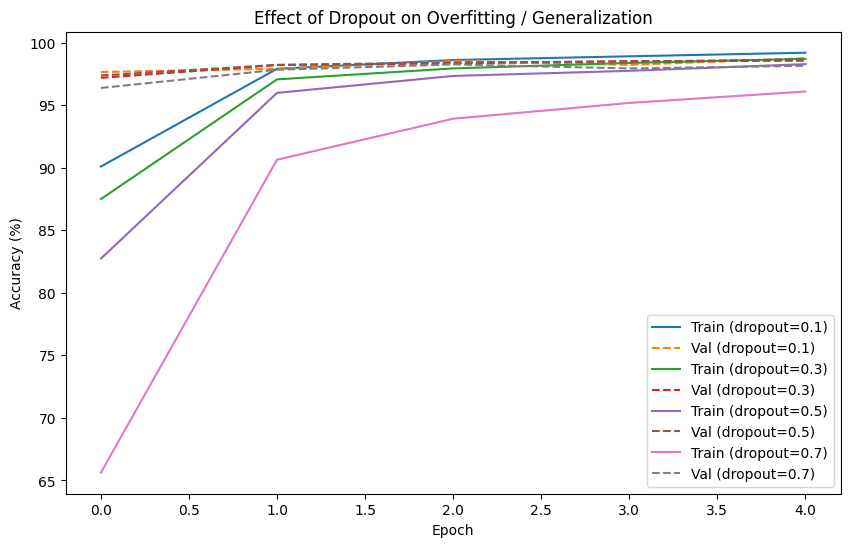

In [17]:
dropout_rates = [0.1, 0.3, 0.5, 0.7]
results = {}

for rate in dropout_rates:
    print(f"\nTraining CNN with Dropout Rate = {rate}")
    model = CNNWithDropout(out_size=10, dropout_rate=rate).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    train_losses, val_losses, train_accuracies, val_accuracies, \
    train_acc_mean, val_acc_mean, train_acc_std, val_acc_std, loss_diff = train_model(model,epochs=5)

    results[rate] = {
        "train_acc": train_accuracies,
        "val_acc": val_accuracies
    }
plt.figure(figsize=(10,6))
for rate in dropout_rates:
    plt.plot(results[rate]["train_acc"], label=f"Train (dropout={rate})")
    plt.plot(results[rate]["val_acc"], '--', label=f"Val (dropout={rate})")

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Effect of Dropout on Overfitting / Generalization")
plt.legend()
plt.show()

Implementing dropout with different rates [0.1, 0.3, 0.5, 0.7] allowed us to study its effect on overfitting and generalization. Lower dropout rates (0.1–0.3) slightly reduced overfitting while maintaining high training accuracy, whereas moderate rates (0.3–0.5) provided the best balance, improving validation accuracy and generalization. Higher dropout (0.7) prevented overfitting but caused underfitting, lowering both training and validation accuracy. Overall, dropout helps regularize the network, reducing reliance on specific neurons and improving the model’s ability to generalize to unseen data.